In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jedbe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load and combine scraped articles
dfw = pd.read_csv('espn_wbball_stories.csv', index_col=0)
dfm = pd.read_csv('espn_mbball_stories.csv', index_col=0)
df = pd.concat([dfw,dfm])
df = df[~df.duplicated()]
df.reset_index(drop=True, inplace=True)

In [3]:
# Redefine the F indicator column
df.drop('F', inplace=True, axis=1)

male_list = ['he', 'him', 'his', 'hes', 'nba', 'nbas']
female_list = ['she', 'her', 'hers', 'shes', 'wnba', 'wnbas']
F = []
for index, item in df.iterrows():
    # If the url contains wnba or womens then make F=1
    if ('/wnba' or '/womens') in item['URL']:
        F.append(1)
    # If the url contains nba or mens then make F=0
    elif ('/nba' or '/mens') in item['URL']:
        F.append(0)
        
    # Otherwise decide the value of F based on the count of gendered pronouns
    elif ('/wnba' or '/womens') and ('/nba' or '/mens') not in item['URL']:
        m_count = 0
        f_count = 0
        txt = re.sub(r"[^\w\s]", '', item['Text'].lower())
        tokens = nltk.word_tokenize(txt)
        for i in tokens:
            if i in male_list:
                m_count += 1
            elif i in female_list:
                f_count += 1

        if f_count >= m_count:
            F.append(1)
        else:
            F.append(0)
            
df['F'] = F

In [4]:
# Add gendered pronouns to the stop words list, along with other words that could easily give away the gender of the article
# like wnba and nba
new_stops = text.ENGLISH_STOP_WORDS.union(['his', 'him','her', "hers", 'he', 'she', 'nba', 'wnba', "hes", "shes", 
                                           "womens", 'women', 'woman', 'men', "mens", "wnbas", 'ncaa', 'nba', 
                                           'college', 'are', 'man','was', 'has', 'said', 'is', 'been'])

In [5]:
# Basic cleaning function to remove formatting characters, non-alphanumerics, and numbers
def basic_clean(txt):
    txt=txt.replace('\r',' ')
    txt=txt.replace('\n',' ')
    txt = re.sub(r"[^\w\s]", ' ', txt)
    txt = re.sub(r"\d+[yd]"," ", txt)
    txt = re.sub(r"\d"," ", txt)
    txt = txt.replace(" s ", " ")   
    txt = txt.lower()
    
    return txt

In [6]:
# This creates an empty list to store the new clean text in
cleantext=[]


# this loops through all the articles in the dataframe df
for i in range(len(df)):
    # This gets the text from the dataframe
    txt=df['Text'][i]      
    txt = basic_clean(txt)
    
    tokens = nltk.word_tokenize(txt)
    no_stops = [t for t in tokens if t not in new_stops]
    txt = " ".join(no_stops)
    
    # These replace some common nonsense strings that appeared frequently in the logit-lasso results
    txt=txt.replace("messengeremailnov",' ')    
    txt=txt.replace('sénéchaluconn', ' ')
    txt=txt.replace('laurensmen', ' ')
    txt=txt.replace('bpinba', ' ')
    txt=txt.replace('logsdon', ' ')
    txt=txt.replace('emmert', ' ')
    txt=txt.replace('pickswomen', ' ')
    txt=txt.replace('fortenbaugh', ' ')
    txt=txt.replace('benzema', ' ')
    txt=txt.replace('insidersbetting', ' ')
    txt = re.sub(r'([A-Za-z])(\d+)([A-Za-z])', r'\1 \3', txt)
    txt = txt.strip()
    
    # This takes out all the extraneous spaces
    rejoin = nltk.word_tokenize(txt)
    txt = " ".join(rejoin)
    cleantext.append(txt)
    
# This creates a new column from the list of cleaned articles
df['clean_text']= cleantext

In [7]:
#df.to_csv("all_bball_clean3.csv")

In [8]:
#df = pd.read_csv('all_bball_clean3.csv', index_col=0)

In [9]:
# Initialize Tfidf vectorizer
tv = TfidfVectorizer(stop_words=new_stops)
X = tv.fit_transform(df['clean_text'])
features = tv.get_feature_names()

In [10]:
# 3 minutes
y = df['F']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680)

# The C values to loop through
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Empty list to store accuracies
acc = []
# Loop through each C, fit the model, and store the accuracy and C value as a tuple
for c in Cs:
    logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=c)
    model = logit.fit(X_train,y_train)
    acc.append((model.score(X_test,y_test), c))
    
print(acc)
# C=10 is the most accurate

[(0.5818181818181818, 0.001), (0.5832167832167832, 0.01), (0.8951048951048951, 0.1), (0.9405594405594405, 1), (0.9328671328671329, 10), (0.9363636363636364, 100), (0.9349650349650349, 1000)]


Accuracy: 0.9370629370629371


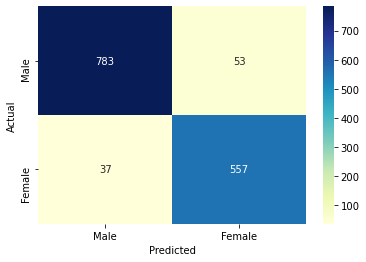

In [11]:
logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=10)
y = df['F']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y)
model = logit.fit(X_train,y_train)
coefs = model.coef_

# This creates a dataframe with every word and its coefficient and the absolute value of its coefficient
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()})
df_coef['abs coef']= df_coef['coef'].abs()

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot a heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu", yticklabels=['Male', 'Female'], xticklabels=['Male', 'Female'],  annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
print('First Iteration: Clean Text, Authors Included')
print('Top 20 Words for Men:')
display(df_coef.sort_values('coef').head(20))

print('Top 20 Words for Women:')
display(df_coef.sort_values('coef', ascending=False).head(20))

First Iteration: Clean Text, Authors Included
Top 20 Words for Men:


,word,coef,abs coef
68573,trade,-57.342245,57.342245
49781,playoffs,-36.941572,36.941572
72847,warriors,-28.771559,28.771559
15815,debate,-26.524140,26.524140
6143,blunders,-23.986729,23.986729
32605,jeff,-23.932226,23.932226
52447,rallied,-22.734060,22.734060
50948,press,-19.428206,19.428206
68066,told,-19.344496,19.344496
17315,director,-19.098760,19.098760


Top 20 Words for Women:


,word,coef,abs coef
49898,pleads,24.336228,24.336228
39171,mechelle,22.518205,22.518205
1384,alexa,20.393750,20.393750
6344,bonagura,18.316005,18.316005
14734,crusaders,16.802685,16.802685
20662,espnw,15.698087,15.698087
33004,jones,14.366291,14.366291
44083,nonphysical,13.614737,13.614737
399,ackerman,13.012421,13.012421
50079,pointer,12.055413,12.055413


In [13]:
# Create a list of author first and last names to remove
auth_tokens = []
for i in set(df['Author'].tolist()):
    if type(i) == str:
        auth_tokens.extend(nltk.word_tokenize(i.lower()))
    
auth_tokens = set(auth_tokens)

In [14]:
cleantext=[]

# Inlcude a new column for stems now also
cleanstems = []
stemmer = SnowballStemmer('english')

for i in range(len(df)):

    txt=df['Text'][i]     
    txt = basic_clean(txt)
    
    for t in auth_tokens:
        if (t not in new_stops) and (len(t) > 3):
            txt = txt.replace(t, ' ')  
        
    tokens = nltk.word_tokenize(txt)
    no_stops = [t for t in tokens if t not in new_stops]
    txt = " ".join(no_stops)
    
    # These replace the nonsense characters again
    txt=txt.replace("messengeremailnov",' ')    
    txt=txt.replace('sénéchaluconn', ' ')
    txt=txt.replace('laurensmen', ' ')
    txt=txt.replace('bpinba', ' ')
    txt=txt.replace('logsdon', ' ')
    txt=txt.replace('emmert', ' ')
    txt=txt.replace('pickswomen', ' ')
    txt=txt.replace('fortenbaugh', ' ')
    txt=txt.replace('benzema', ' ')
    txt=txt.replace('kentuckykentucky', ' ')
    txt=txt.replace('hjulien', ' ')
    txt=txt.replace('kavanaghhow', ' ')
    txt = re.sub(r'([A-Za-z])(\d+)([A-Za-z])', r'\1 \3', txt)
    txt = txt.strip()
    
    rejoin = nltk.word_tokenize(txt)
    stems = [stemmer.stem(s) for s in rejoin]
    txt = " ".join(rejoin)
    txt_stems = " ".join(stems)
    
    cleantext.append(txt)
    cleanstems.append(txt_stems)
    
# This creates new columns from the list of cleaned articles and stemmed words
df['clean_text']= cleantext
df['clean_stems'] = cleanstems

Accuracy: 0.9454545454545454


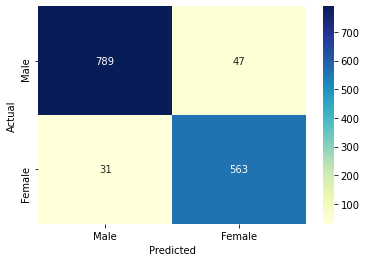

In [15]:
# Initialize a new Tfidf vectorizer and run the regression again
tv = TfidfVectorizer(stop_words=new_stops)
X = tv.fit_transform(df['clean_text'])
features = tv.get_feature_names()

logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=10)
y = df['F']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y)
model = logit.fit(X_train,y_train)
coefs = model.coef_

df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()})
df_coef['abs coef']= df_coef['coef'].abs()

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu", yticklabels=['Male', 'Female'], xticklabels=['Male', 'Female'],  annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
print('Second Iteration: Clean Text, Authors Excluded')
print('Top 20 Words for Men:')
display(df_coef.sort_values('coef').head(20))

print('Top 20 Words for Women:')
display(df_coef.sort_values('coef', ascending=False).head(20))

Second Iteration: Clean Text, Authors Excluded
Top 20 Words for Men:


,word,coef,abs coef
63053,warriors,-56.525768,56.525768
1904,anniversary,-52.489888,52.489888
43593,playoffs,-21.607690,21.607690
13834,deep,-20.333700,20.333700
13628,debate,-19.808619,19.808619
46101,rallied,-19.697073,19.697073
5510,blunders,-18.693608,18.693608
53422,slow,-18.357816,18.357816
24323,heisman,-17.847267,17.847267
21831,geno,-16.824261,16.824261


Top 20 Words for Women:


,word,coef,abs coef
6277,bre,25.430645,25.430645
24472,heroics,23.207692,23.207692
43706,pleads,22.543436,22.543436
55592,storm,19.633351,19.633351
38378,nonphysical,18.672887,18.672887
9058,check,15.587688,15.587688
7904,carla,14.376466,14.376466
56492,surprises,14.308122,14.308122
12611,crusaders,13.586957,13.586957
14234,denise,13.488986,13.488986


Accuracy: 0.9356643356643357


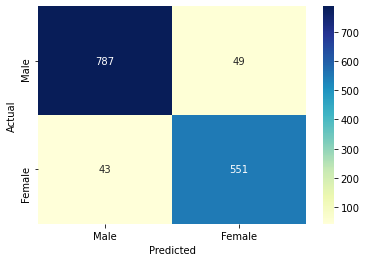

In [17]:
# Intitialize another Tfidf vectorizer for the stems and run the regression one more time
tv = TfidfVectorizer(stop_words=new_stops)
X = tv.fit_transform(df['clean_stems'])
features = tv.get_feature_names()

logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=10)
y = df['F']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680, stratify=y)
model = logit.fit(X_train,y_train)
coefs = model.coef_

df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()})
df_coef['abs coef']= df_coef['coef'].abs()

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu", yticklabels=['Male', 'Female'], xticklabels=['Male', 'Female'],  annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
print('Third Iteration: Stemmed Text')
print('Top 20 Words for Men:')
display(df_coef.sort_values('coef').head(20))

print('Top 20 Words for Women:')
display(df_coef.sort_values('coef', ascending=False).head(20))

Third Iteration: Stemmed Text
Top 20 Words for Men:


,word,coef,abs coef
49389,warrior,-44.488275,44.488275
1381,anniversari,-44.074776,44.074776
10650,deep,-19.587025,19.587025
36976,reev,-19.235820,19.235820
35987,qualifi,-18.930249,18.930249
50141,wife,-18.071670,18.071670
44041,suppos,-17.727846,17.727846
4232,blunder,-17.431987,17.431987
41826,slow,-17.369331,17.369331
21670,jay,-16.445680,16.445680


Top 20 Words for Women:


,word,coef,abs coef
20938,instruct,23.013208,23.013208
43487,storm,21.543620,21.543620
4837,bre,21.529438,21.529438
34589,plead,20.835956,20.835956
18631,heroic,18.140291,18.140291
41187,shoot,15.381352,15.381352
44654,taurasi,14.513999,14.513999
3173,basket,14.445674,14.445674
40551,senior,14.398043,14.398043
6131,carla,12.767242,12.767242
